https://tomdecroos.github.io/reports/playing-style-wide-v2.pdf

In [1]:
import pandas as pd
import numpy as np
from mplfooty.pitch import Pitch
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter
import seaborn as sns
import matplotlib.pyplot as plt
import itertools


from utils import load_display_options, ignore_warnings
load_display_options()
ignore_warnings()

Load Chain Data

In [2]:
chains = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_chains_v2.csv")
chains['Season'] = chains['Match_ID'].apply(lambda x: int(x[:4]))

In [105]:
chains[['Description', 'action_type']].head()

,Description,action_type
0,Hard Ball Get,Carry
1,Handball,Handball
2,Loose Ball Get,Carry
3,Handball,Handball
4,Handball Received,Carry


In [3]:
chains['Receiver'] = chains.groupby('Match_ID').shift(-1)['Player']

1. Select Relevant Action Types

In [4]:
carries = chains[chains['action_type'] == "Carry"]
handballs = chains[chains['action_type'] == "Handball"]
kicks = chains[(chains['action_type'] == "Kick") & (chains['Shot_At_Goal'] != True)]
shots = chains[chains['Shot_At_Goal'] == True]

2. Construct Heatmaps per Player per Action Type

In [5]:
player_list = list(set(chains['Player']))
season_list = list(chains['Season'].unique())
pitch = Pitch(pitch_length=160, pitch_width=141)

In [6]:
player_season_list = list(itertools.product(player_list, season_list))
# player_season_list

In [7]:
def create_player_year_action_heatmap(action_data, xy="start"):
    action_dict = {
        (player, season): gaussian_filter(
            pitch.bin_statistic(action_data[(action_data['Player'] == player) & (action_data['Season'] == season)]['left_right_' + xy + '_x'],
                                action_data[(action_data['Player'] == player) & (action_data['Season'] == season)]['left_right_' + xy + '_y'],
                                statistic='count', bins=(50, 50), normalize=True)['statistic']
            , 1)
        for player, season in itertools.product(player_list, season_list)
        if not action_data[(action_data['Player'] == player) & (action_data['Season'] == season)].empty
    }

    return action_dict

In [8]:
kick_start_dict = create_player_year_action_heatmap(kicks, xy="start")
kick_end_dict = create_player_year_action_heatmap(kicks, xy="end")

handball_start_dict = create_player_year_action_heatmap(handballs, xy="start")
handball_end_dict = create_player_year_action_heatmap(handballs, xy="end")

carry_dict = create_player_year_action_heatmap(carries)
shot_dict = create_player_year_action_heatmap(shots)

In [9]:
def create_receiver_year_action_heatmap(action_data, xy="start"):
    action_dict = {
        (player, season): gaussian_filter(
            pitch.bin_statistic(action_data[(action_data['Receiver'] == player) & (action_data['Season'] == season)]['left_right_' + xy + '_x'],
                                action_data[(action_data['Receiver'] == player) & (action_data['Season'] == season)]['left_right_' + xy + '_y'],
                                statistic='count', bins=(50, 50), normalize=True)['statistic']
            , 1)
        for player, season in itertools.product(player_list, season_list)
        if not action_data[(action_data['Receiver'] == player) & (action_data['Season'] == season)].empty
    }

    return action_dict

In [10]:
kick_receiver_dict = create_receiver_year_action_heatmap(kicks, xy="end")
handball_receiver_dict = create_receiver_year_action_heatmap(handballs, xy="end")

In [11]:
def filter_dict_by_keys(input_dict, key_list):
    return {key: input_dict[key] for key in key_list if key in input_dict}

In [12]:
dicts = [kick_start_dict, kick_end_dict, handball_start_dict, handball_end_dict, carry_dict, shot_dict, kick_receiver_dict, handball_receiver_dict]
common_keys_set = set.intersection(*[set(d.keys()) for d in dicts])

In [13]:
kick_start_dict = filter_dict_by_keys(kick_start_dict, common_keys_set)
kick_end_dict = filter_dict_by_keys(kick_end_dict, common_keys_set)
handball_start_dict = filter_dict_by_keys(handball_start_dict, common_keys_set)
handball_end_dict = filter_dict_by_keys(handball_end_dict, common_keys_set)
carry_dict = filter_dict_by_keys(carry_dict, common_keys_set)
shot_dict = filter_dict_by_keys(shot_dict, common_keys_set)
kick_receiver_dict = filter_dict_by_keys(kick_receiver_dict, common_keys_set)
handball_receiver_dict = filter_dict_by_keys(handball_receiver_dict, common_keys_set)

In [14]:
def plot_action_heatmap(action_dict, player_name, season, xy = "start"):
    
    plotting = pitch.bin_statistic(shots['left_right_'+xy+'_x'], shots['left_right_'+xy+'_y'], bins = (50, 50))
    plotting['statistic'] = action_dict[(player_name, season)]
    fig, ax = pitch.draw()
    pitch.heatmap(plotting, ax=ax)
    
    return fig, ax

(<Figure size 640x480 with 1 Axes>, <Axes: >)

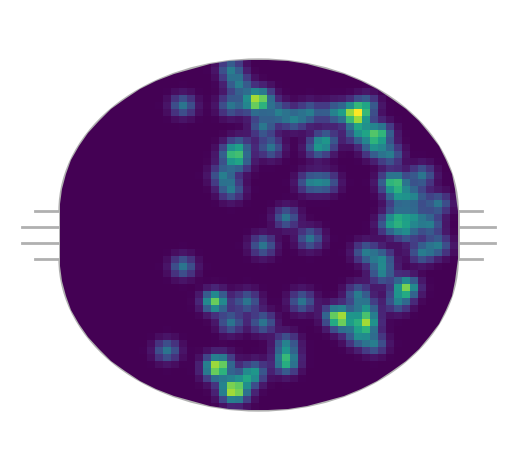

In [107]:
plot_action_heatmap(handball_start_dict, "Charlie Curnow", 2023)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

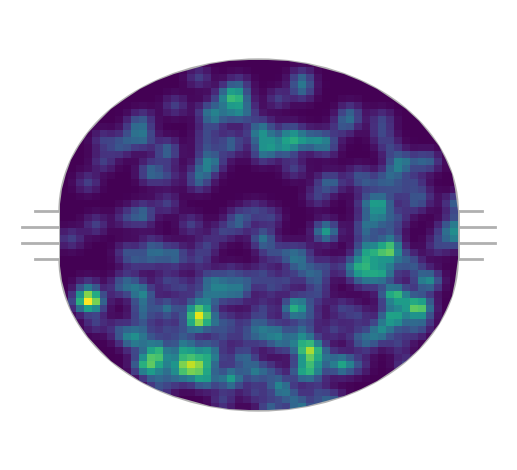

In [16]:
plot_action_heatmap(kick_end_dict, "Nick Daicos", 2023, xy="end")

3. Compress Heatmaps to Vectors

In [17]:
kick_start_vectors = {key: value.flatten() for key, value in kick_start_dict.items()}
kick_end_vectors = {key: value.flatten() for key, value in kick_end_dict.items()}
carry_vectors = {key: value.flatten() for key, value in carry_dict.items()}
handball_start_vectors = {key: value.flatten() for key, value in handball_start_dict.items()}
handball_end_vectors = {key: value.flatten() for key, value in handball_end_dict.items()}
shot_vectors = {key: value.flatten() for key, value in shot_dict.items()}
kick_receiver_vectors = {key: value.flatten() for key, value in kick_receiver_dict.items()}
handball_receiver_vectors = {key: value.flatten() for key, value in handball_receiver_dict.items()}

In [18]:
def column_stack_vectors_to_matrix(vectors):
    
    vector_list = [vectors[name] for name in list(vectors.keys())]
    vector_matrix = np.column_stack(vector_list)
    
    return vector_matrix

In [19]:
kick_start_matrix = column_stack_vectors_to_matrix(kick_start_vectors)
kick_end_matrix = column_stack_vectors_to_matrix(kick_end_vectors)
handball_start_matrix = column_stack_vectors_to_matrix(handball_start_vectors)
handball_end_matrix = column_stack_vectors_to_matrix(handball_end_vectors)
carry_matrix = column_stack_vectors_to_matrix(carry_vectors)
shot_matrix = column_stack_vectors_to_matrix(shot_vectors)
kick_receiver_matrix = column_stack_vectors_to_matrix(kick_receiver_vectors)
handball_receiver_matrix = column_stack_vectors_to_matrix(handball_receiver_vectors)

Apply NMF

In [20]:
def apply_nmf(vector_matrix, number_of_components=4):
    
    model = NMF(n_components=number_of_components)
    principal_components = model.fit_transform(vector_matrix)
    compressed_vectors = model.components_
    
    return principal_components, compressed_vectors

In [21]:
kick_start_principal_components, kick_start_compressed_vectors = apply_nmf(kick_start_matrix, 4)

Reconstructable

In [112]:
reconstructed_kick_start_vector = np.matmul(kick_start_principal_components, kick_start_compressed_vectors[:, 3])
reconstructed_kick_start_heatmap = reconstructed_kick_start_vector.reshape(50, 50)

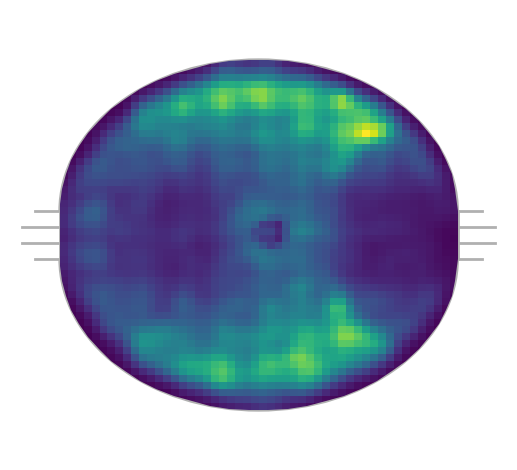

In [113]:
plotting = pitch.bin_statistic(kicks['left_right_start_x'], kicks['left_right_start_y'], bins = (50, 50))
plotting['statistic'] = reconstructed_kick_start_heatmap

fig, ax = pitch.draw()
pitch.heatmap(plotting, ax=ax)

Principal Components are Achetypal Action Types

In [114]:
def plot_action_principal_components(principal_components, num_components):
    
    pitch = Pitch(pitch_width=135, pitch_length=165, line_zorder=4, line_width=1, line_colour="grey", line_alpha=0.5)
    fig, axs = pitch.grid(nrows = 1, ncols = num_components,
                        axis=False)
    for idx, ax in enumerate(axs['pitch'].flat):
        pc_matrix = principal_components[:, idx].reshape(50, 50)
        plotting = pitch.bin_statistic(shots['left_right_start_x'], shots['left_right_start_y'], bins = (50, 50))
        plotting['statistic'] = pc_matrix
        pitch.heatmap(plotting, ax=ax, cmap="GnBu")
    
    return fig, ax

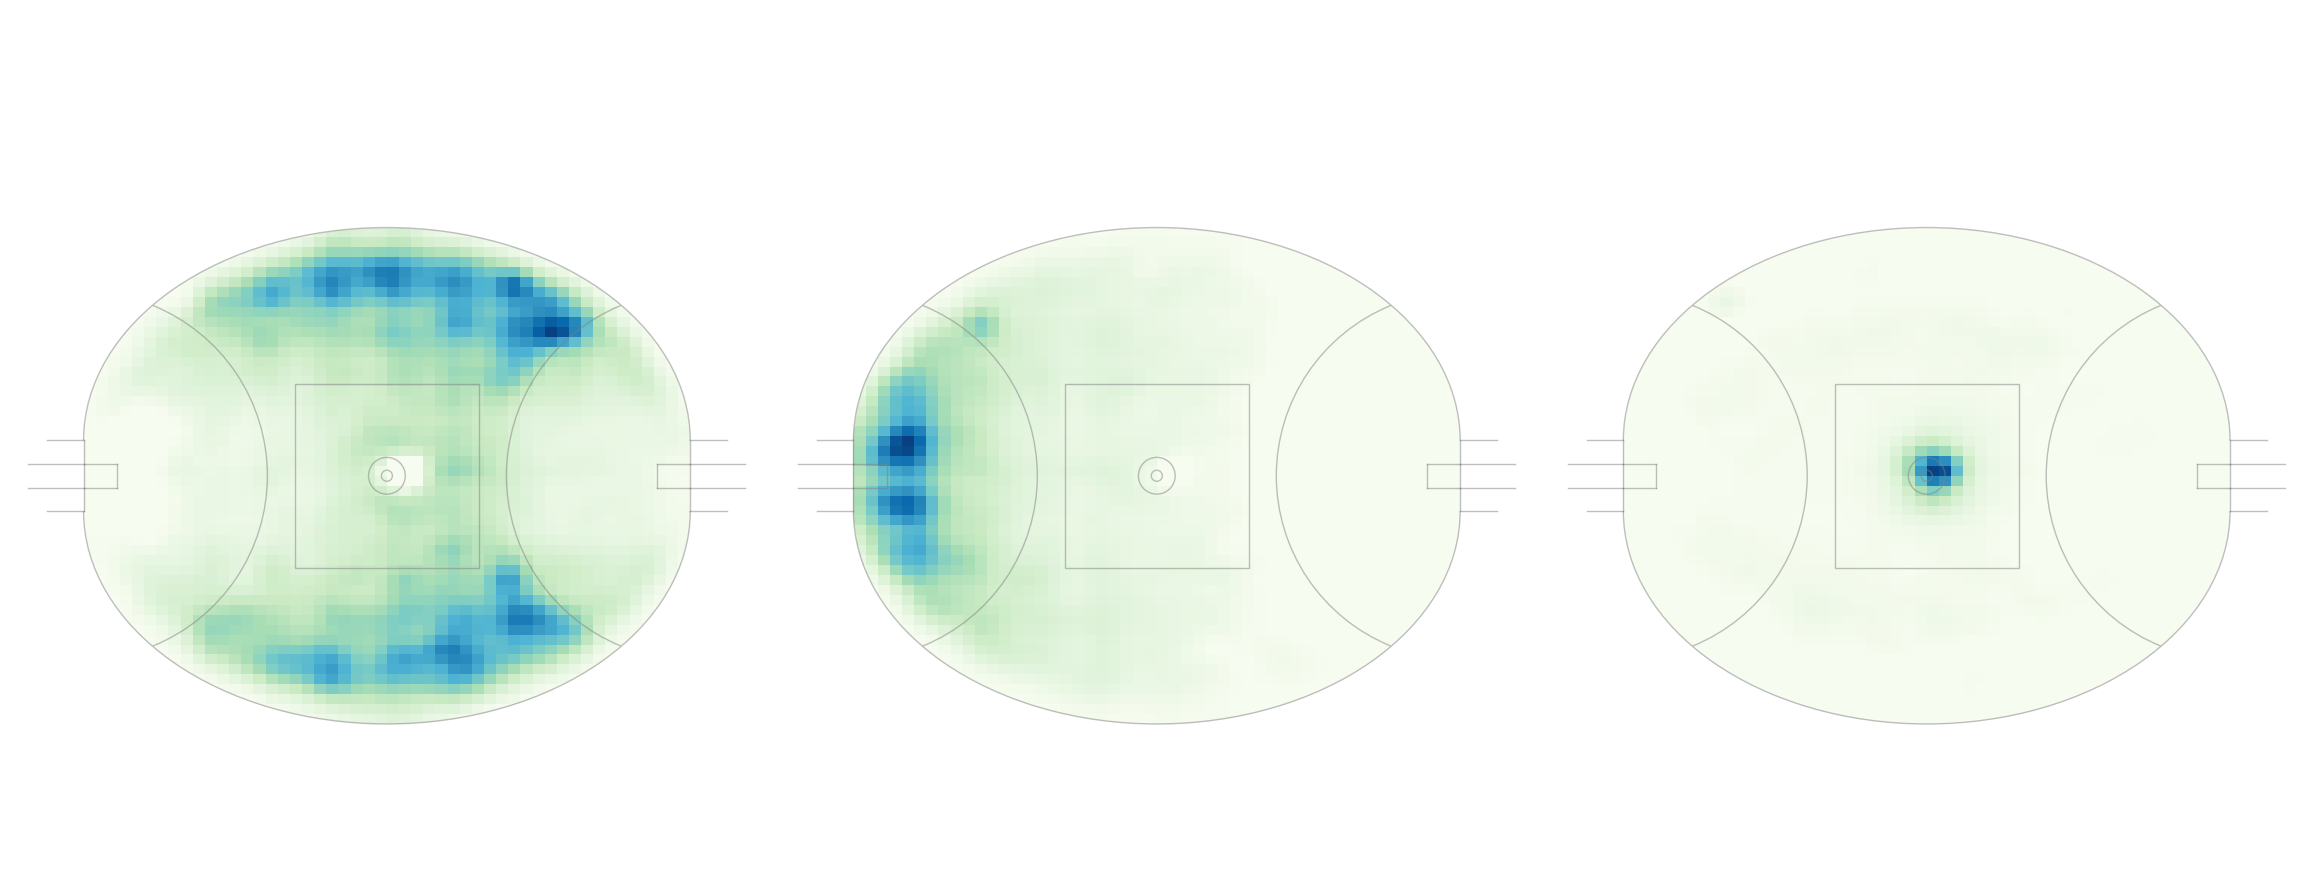

In [118]:
num_kick_start_components = 3
kick_start_principal_components, kick_start_compressed_vectors = apply_nmf(kick_start_matrix, num_kick_start_components)
fig, ax = plot_action_principal_components(kick_start_principal_components, num_kick_start_components)

In [29]:
kick_start_component_names = ['kick_start_wings', 'kick_start_defensive50', 'kick_start_centre_square']

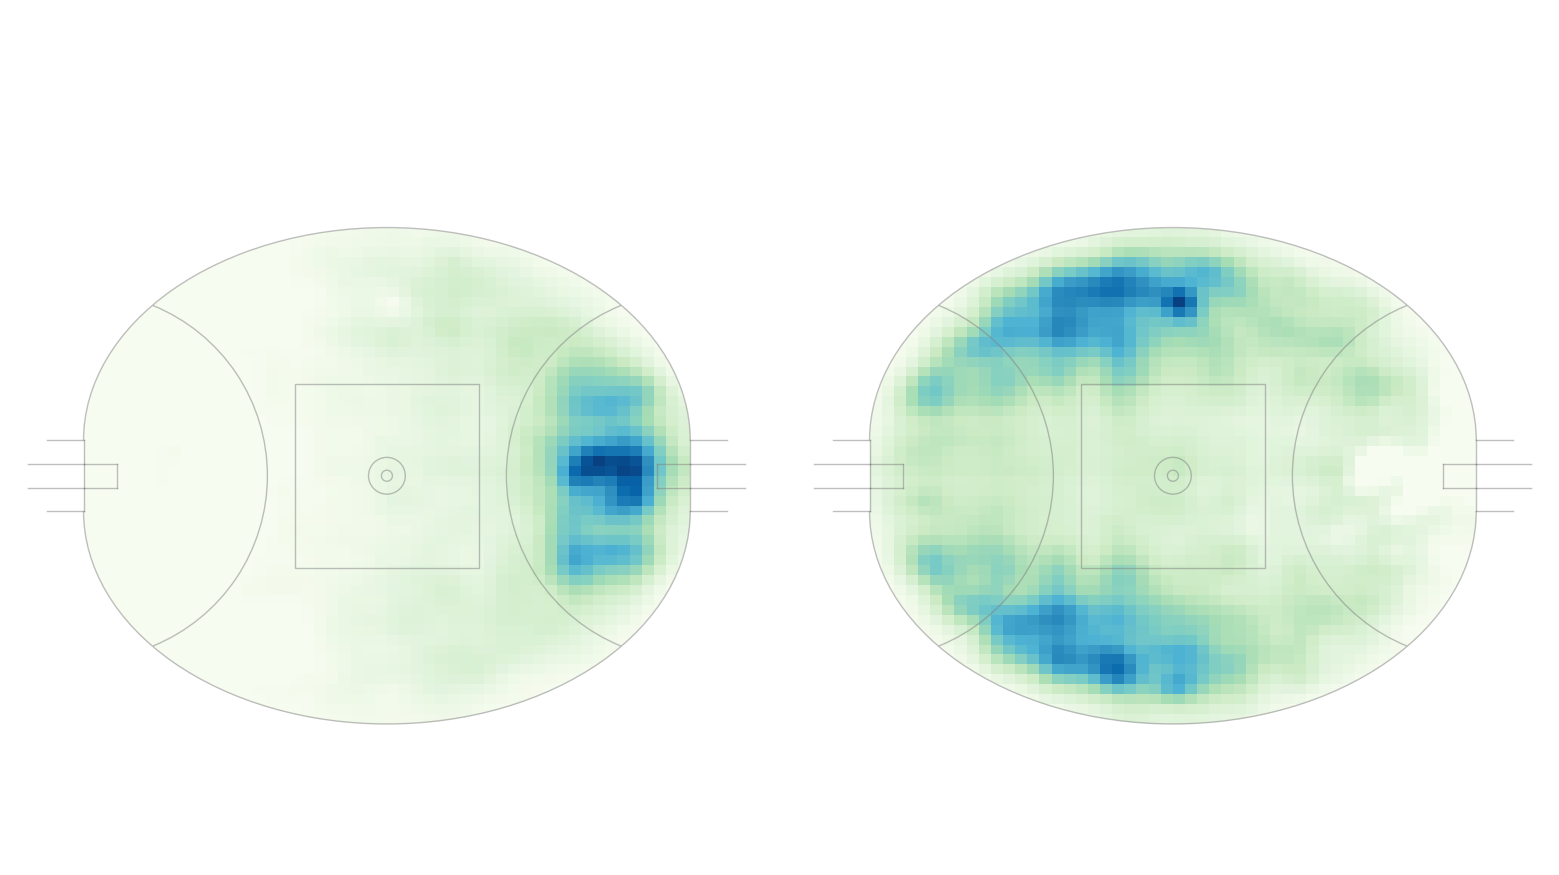

In [120]:
num_kick_end_components = 2
kick_end_principal_components, kick_end_compressed_vectors = apply_nmf(kick_end_matrix, num_kick_end_components)
fig, ax = plot_action_principal_components(kick_end_principal_components, num_kick_end_components)

In [58]:
kick_end_component_names = ['kick_end_forward50', 'kick_end_wings']

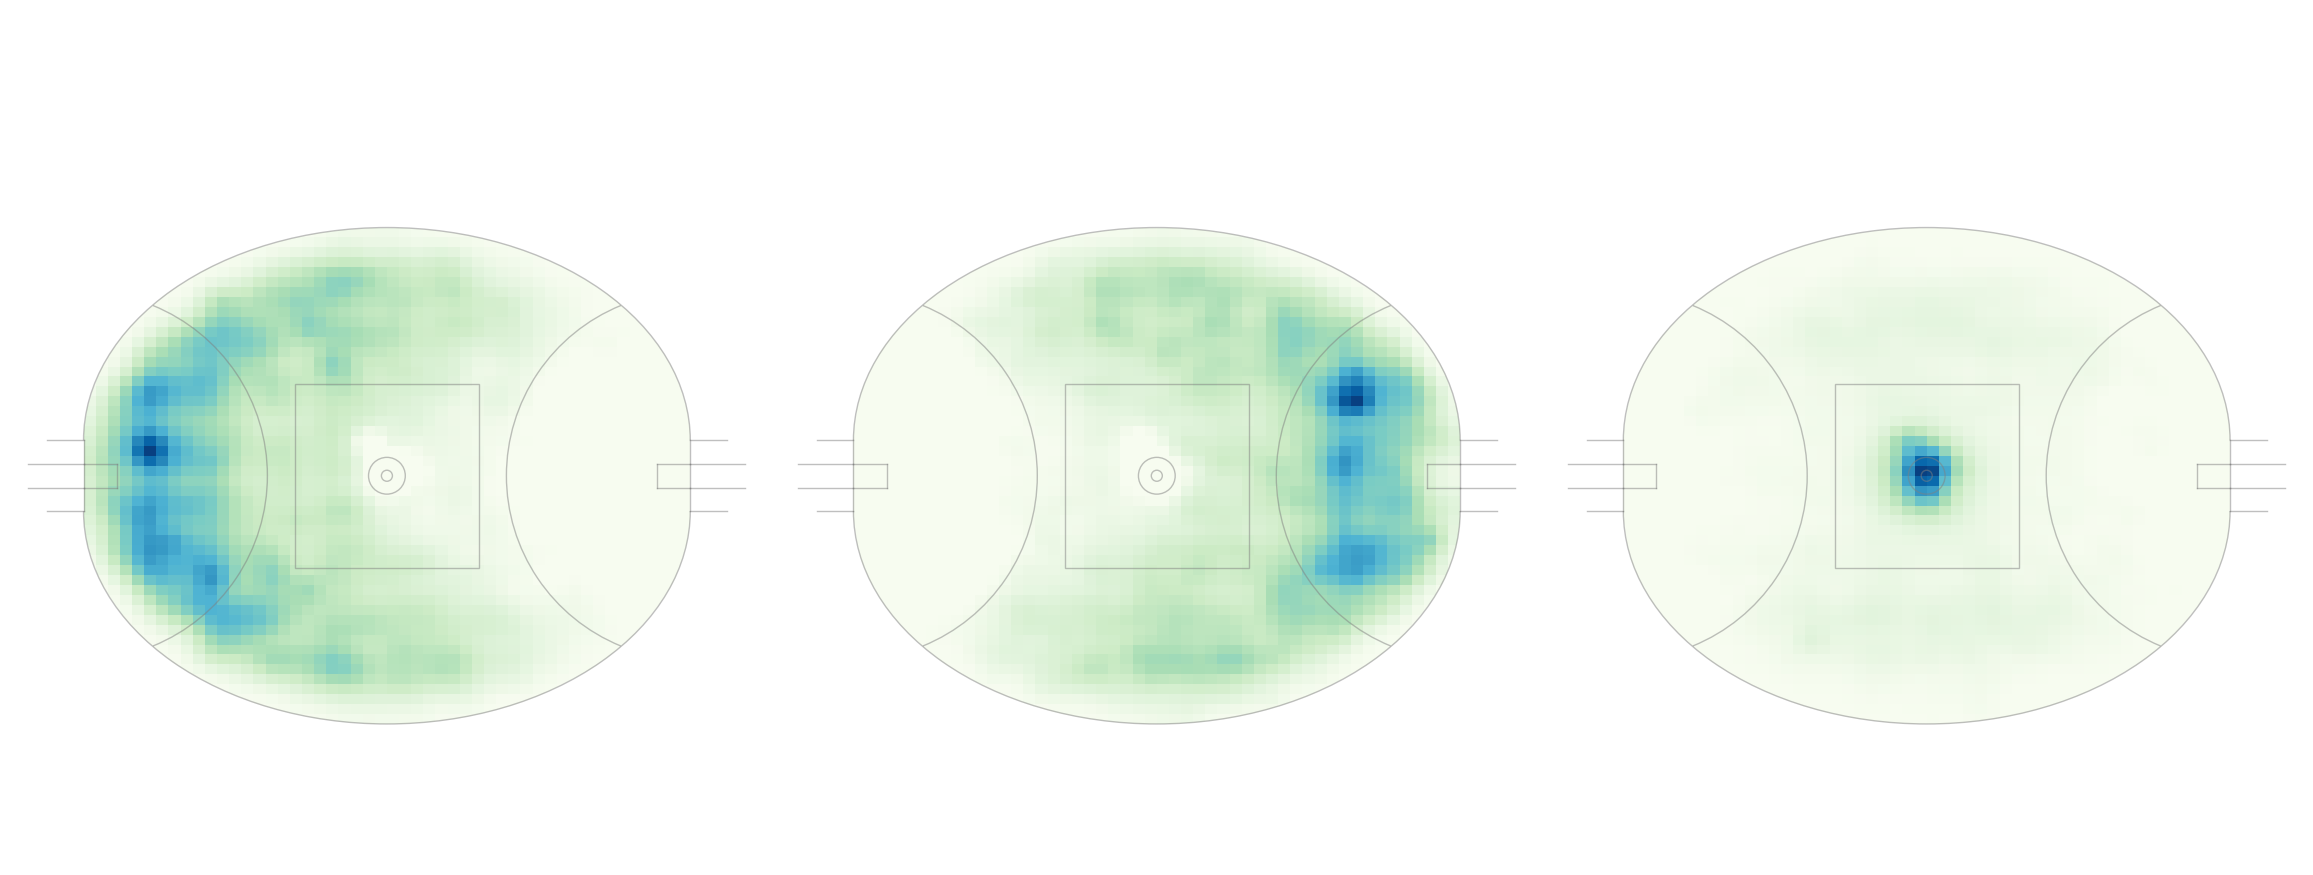

In [59]:
num_components = 3
handball_start_principal_components, handball_start_compressed_vectors = apply_nmf(handball_start_matrix, num_components)
fig, ax = plot_action_principal_components(handball_start_principal_components, num_components)

In [60]:
handball_start_component_names = ['handball_start_defensive50','handball_start_forward50', 'handball_start_centre_square']

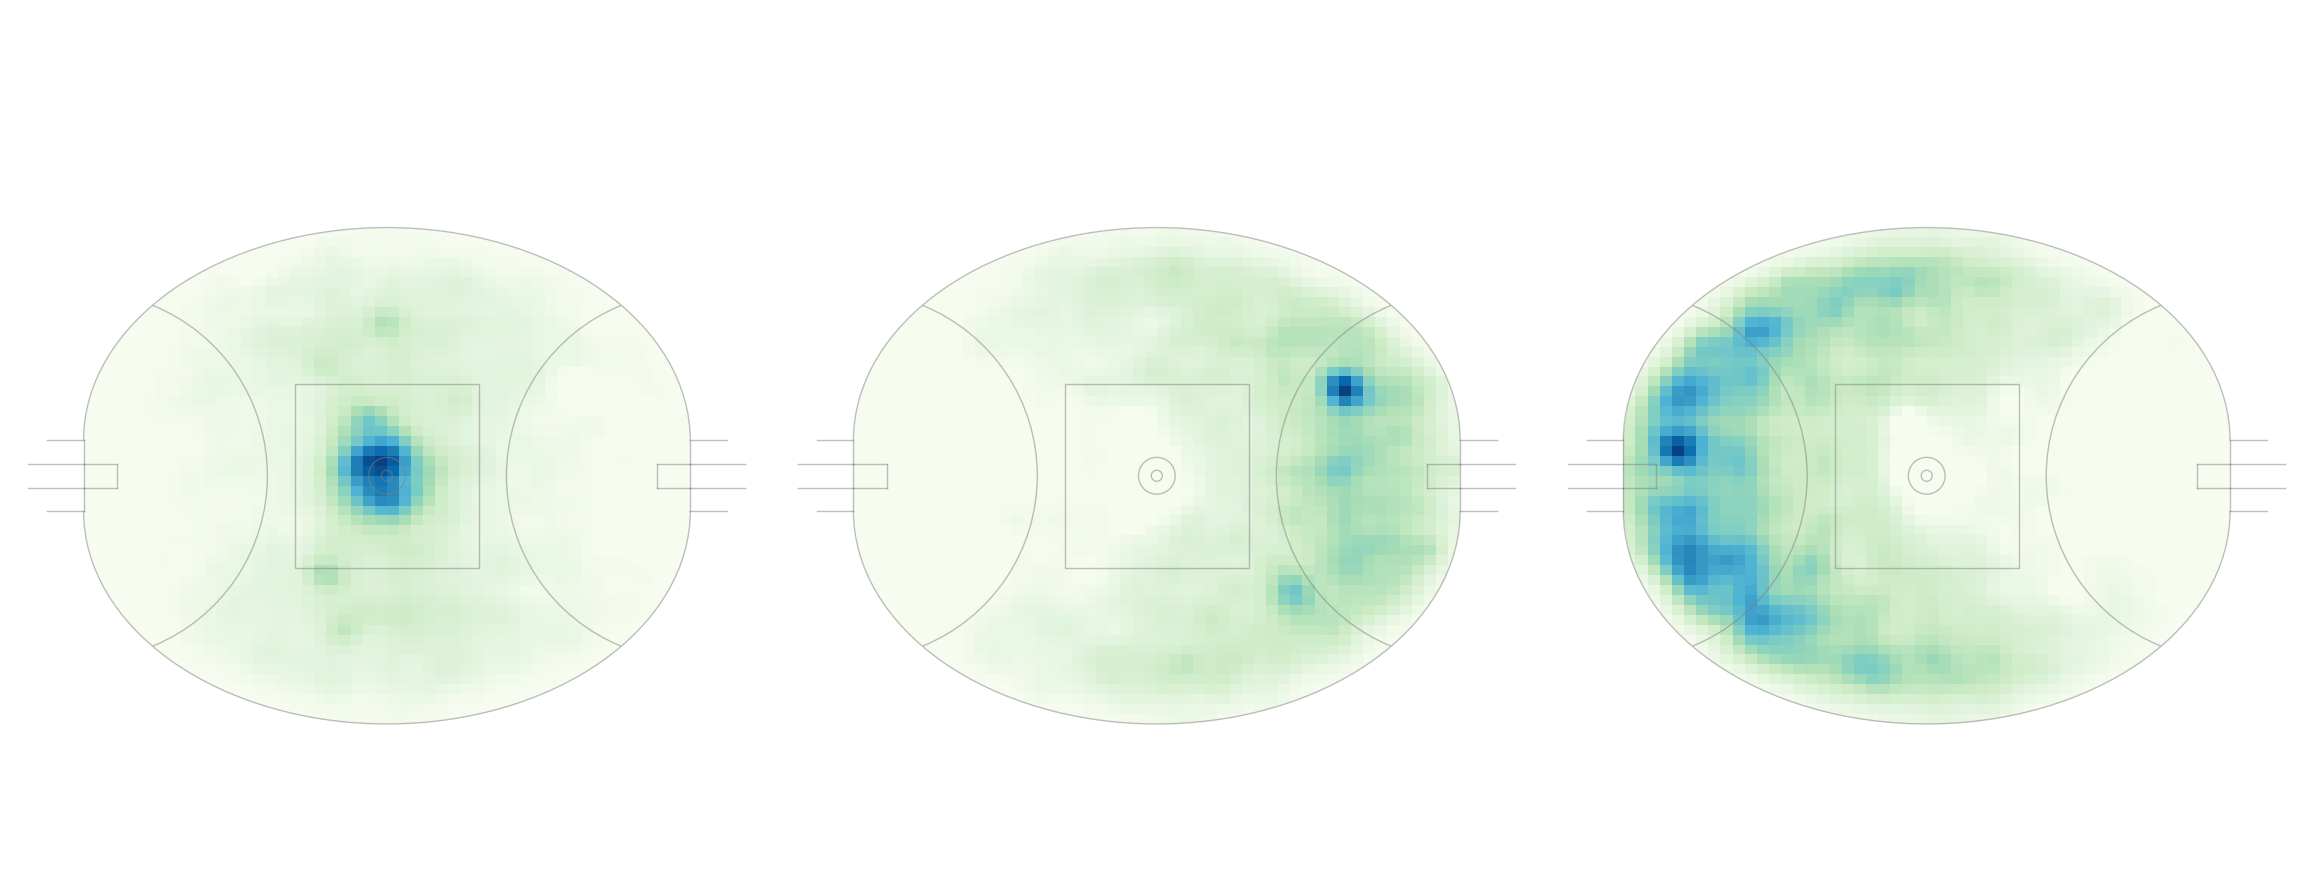

In [61]:
num_components = 3
handball_end_principal_components, handball_end_compressed_vectors = apply_nmf(handball_end_matrix, num_components)
fig, ax = plot_action_principal_components(handball_end_principal_components, num_components)

In [62]:
handball_end_component_names = ['handball_end_centre_square', 'handball_end_forward50', 'handball_end_defensive50' ]

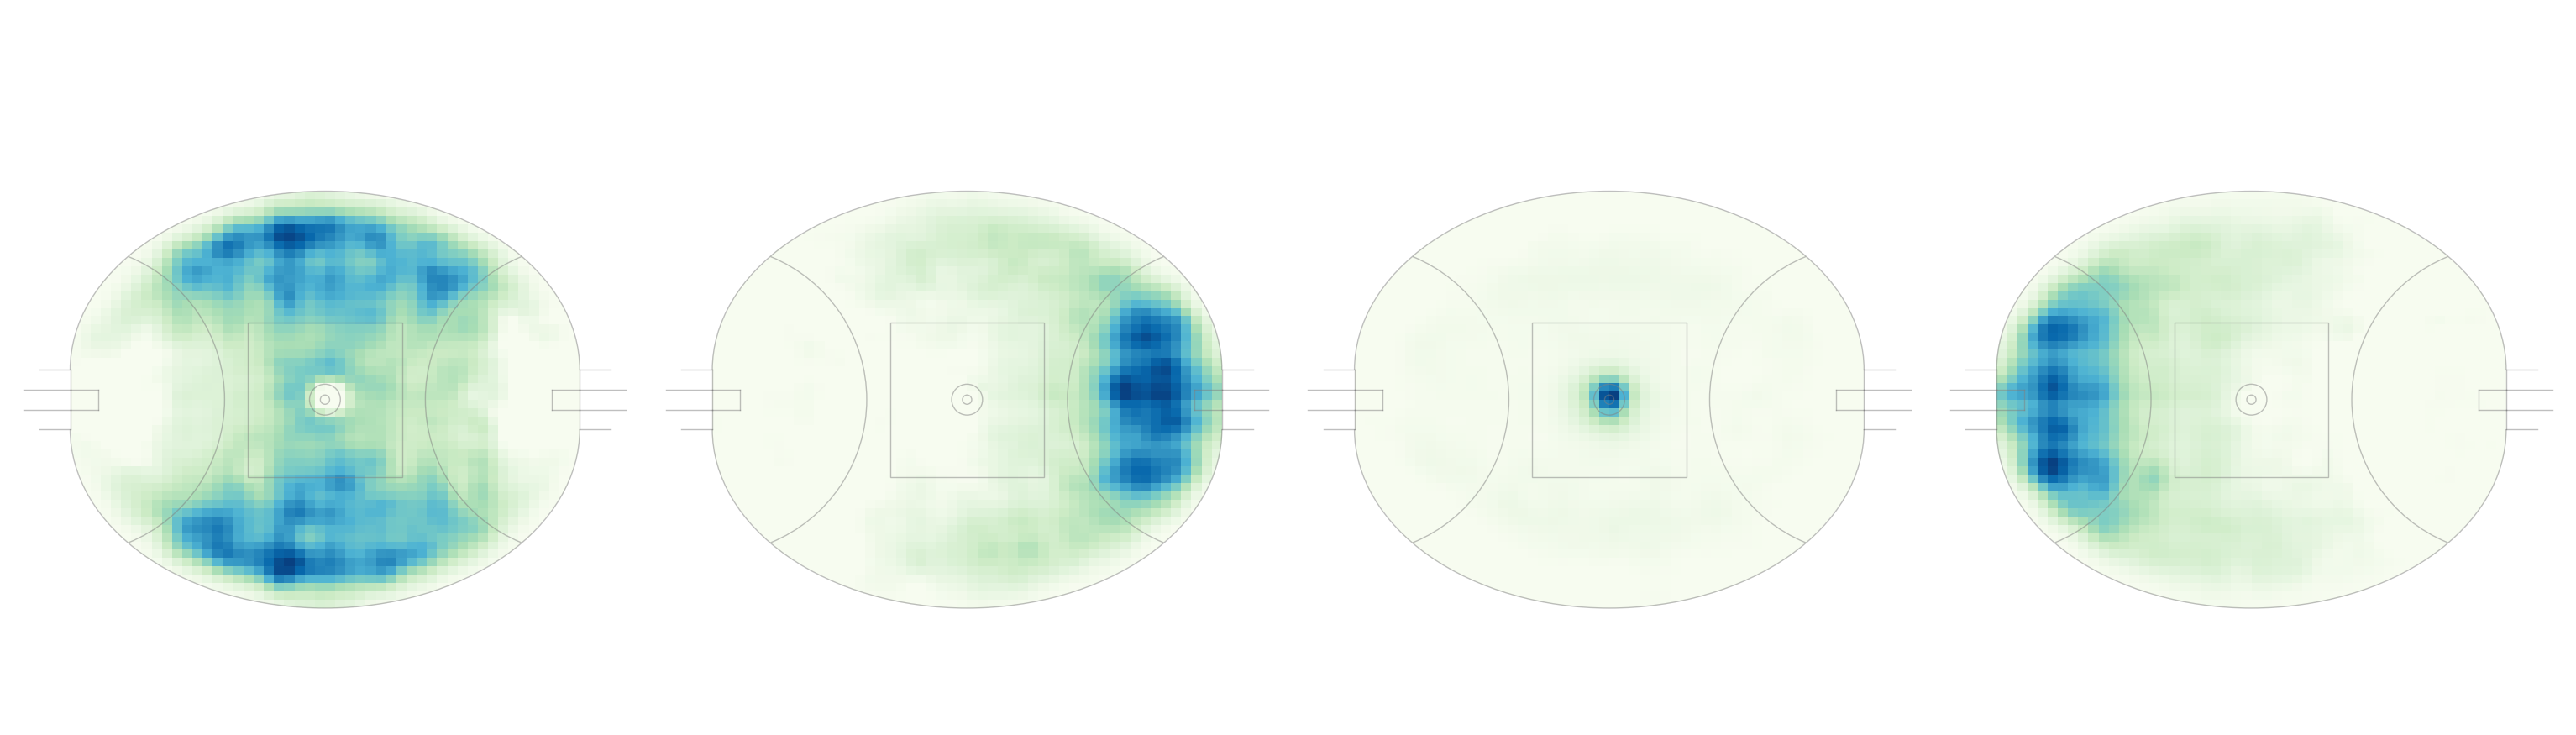

In [63]:
num_components = 4
carry_principal_components, carry_compressed_vectors = apply_nmf(carry_matrix, num_components)
fig, ax = plot_action_principal_components(carry_principal_components, num_components)

In [64]:
carry_component_names = ['carry_wings','carry_forward50', 'carry_centre_square', 'carry_defensive50']

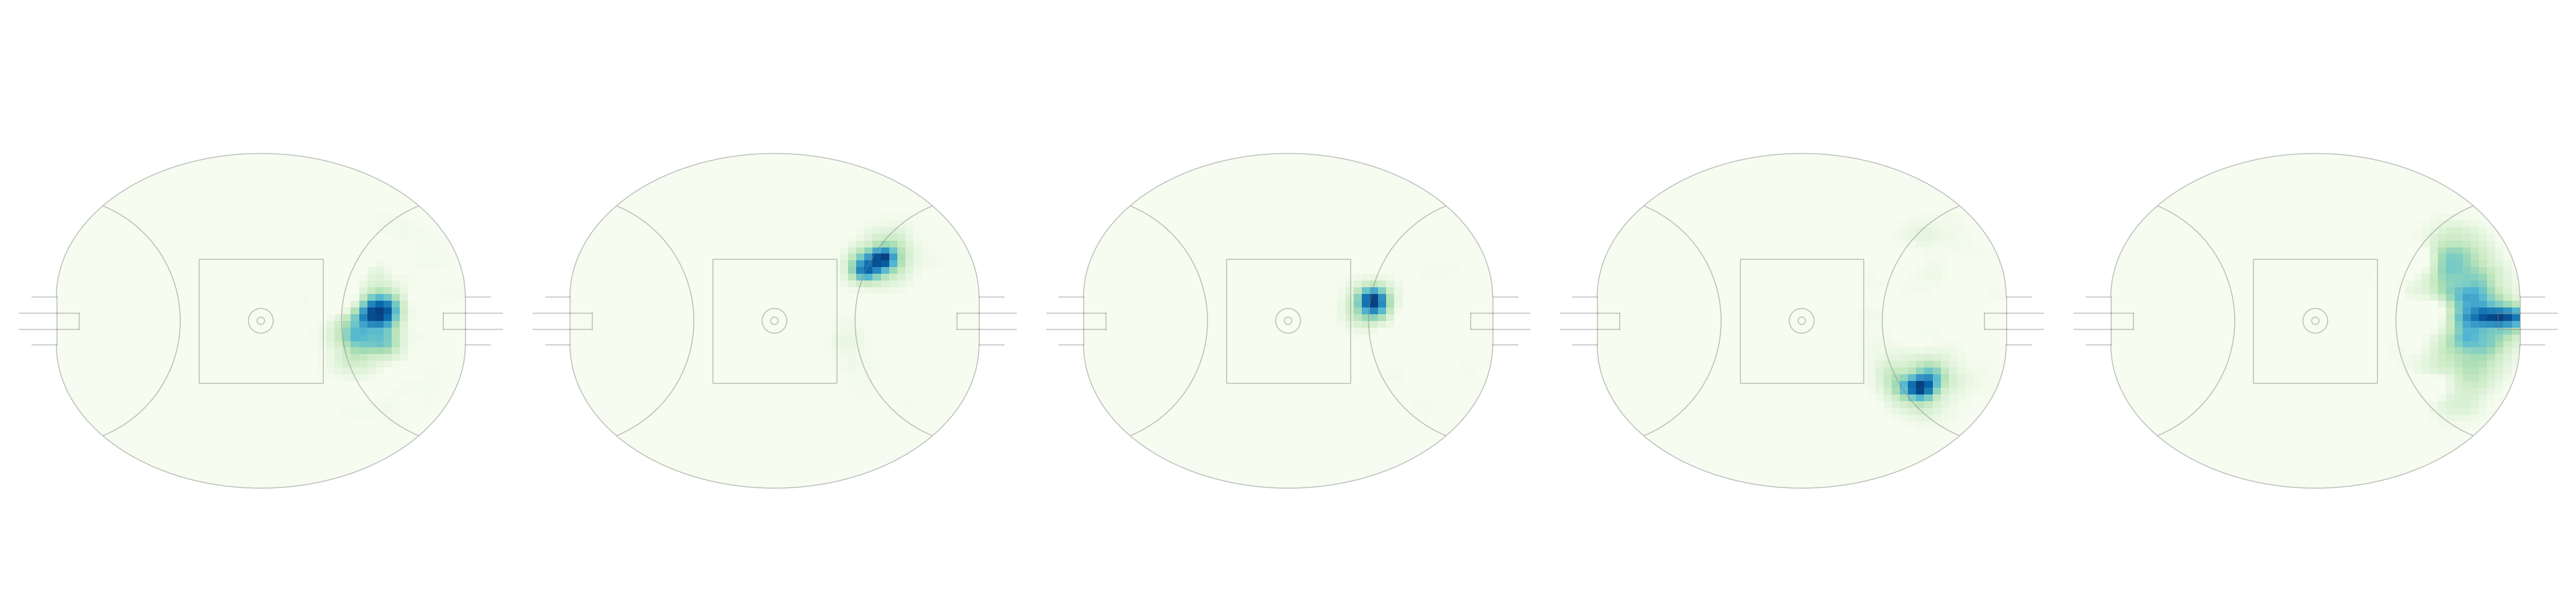

In [65]:
num_components = 5
shot_principal_components, shot_compressed_vectors = apply_nmf(shot_matrix, num_components)
fig, ax = plot_action_principal_components(shot_principal_components, num_components)

In [66]:
shot_component_names = ['shot_middle_centre', 'shot_far_left', 'shot_far_centre', 'shot_far_right', 'shot_goal_square']

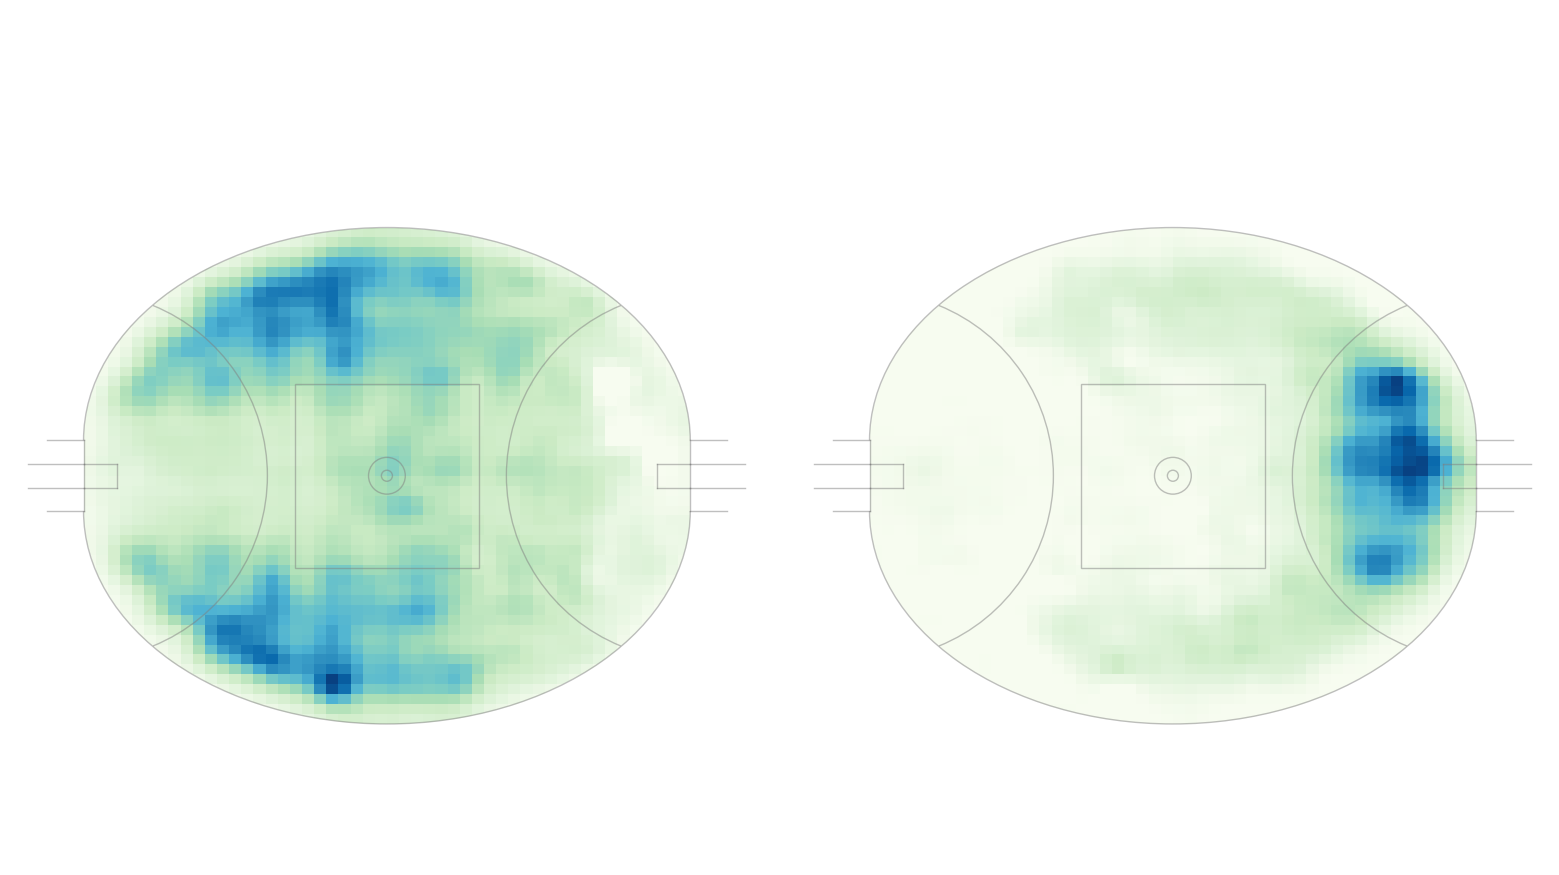

In [67]:
num_components = 2
kick_receiver_principal_components, kick_receiver_compressed_vectors = apply_nmf(kick_receiver_matrix, num_components)
fig, ax = plot_action_principal_components(kick_receiver_principal_components, num_components)

In [68]:
kick_receiver_component_names = ['kick_receiver_wings', 'kick_receiver_forward50']

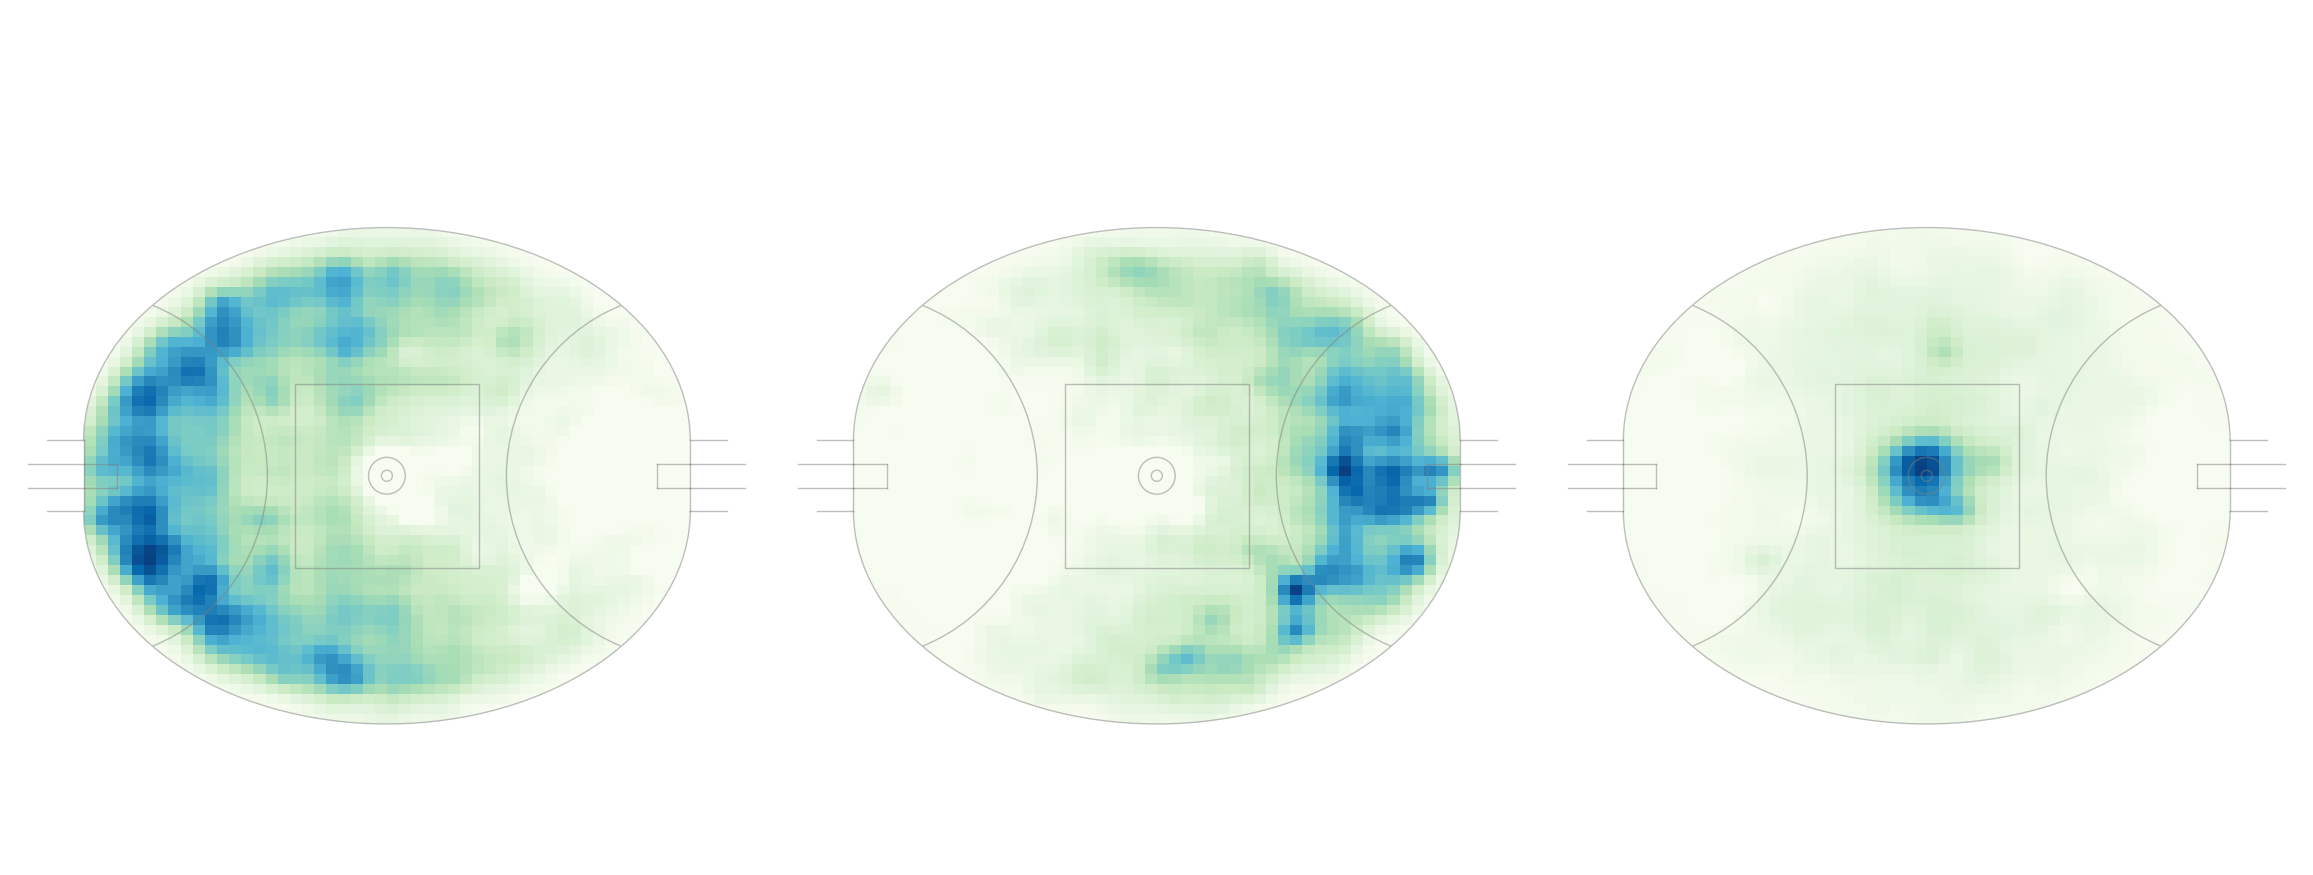

In [69]:
num_components = 3
handball_receiver_principal_components, handball_receiver_compressed_vectors = apply_nmf(handball_receiver_matrix, num_components)
fig, ax = plot_action_principal_components(handball_receiver_principal_components, num_components)

In [70]:
handball_receiver_component_names = ['handball_receiver_wings', 'handball_receiver_forward50', 'handball_receiver_centre_square']

4. Assemble Player Vectors

In [71]:
player_vectors = np.row_stack((kick_start_compressed_vectors, kick_end_compressed_vectors,
                               handball_start_compressed_vectors, handball_end_compressed_vectors,
                               carry_compressed_vectors, shot_compressed_vectors,
                               kick_receiver_compressed_vectors, handball_receiver_compressed_vectors))
player_vectors.shape

(25, 1724)

In [72]:
player_vectors_df = pd.DataFrame(player_vectors.T, index = pd.MultiIndex.from_tuples(list(kick_end_dict.keys())))
player_vectors_df.columns = kick_start_component_names + kick_end_component_names + handball_start_component_names + handball_end_component_names + carry_component_names + shot_component_names + kick_receiver_component_names + handball_receiver_component_names
player_vectors_df.head()

,,kick_start_wings,kick_start_defensive50,kick_start_centre_square,kick_end_forward50,kick_end_wings,handball_start_defensive50,handball_start_forward50,handball_start_centre_square,handball_end_centre_square,handball_end_forward50,handball_end_defensive50,carry_wings,carry_forward50,carry_centre_square,carry_defensive50,shot_middle_centre,shot_far_left,shot_far_centre,shot_far_right,shot_goal_square,kick_receiver_wings,kick_receiver_forward50,handball_receiver_wings,handball_receiver_forward50,handball_receiver_centre_square
Billy Frampton,2021,0.012830,0.023113,0.001950,0.006932,0.022790,0.017172,0.016978,0.002974,0.009073,0.013394,0.018310,0.013420,0.014549,0.000000,0.022241,0.008546,0.014559,0.019332,0.019349,0.022099,0.016675,0.017983,0.016480,0.019134,0.002797
Dan Houston,2022,0.013326,0.024107,0.002607,0.006767,0.023596,0.026181,0.004958,0.005329,0.010988,0.003830,0.024625,0.022801,0.000000,0.002036,0.024093,0.018646,0.043696,0.008348,0.001356,0.000807,0.023086,0.008608,0.019111,0.006569,0.011012
Ben Brown,2021,0.036275,0.000000,0.000000,0.031883,0.004230,0.000000,0.025097,0.013256,0.011586,0.020575,0.004640,0.006540,0.036913,0.002353,0.000178,0.019826,0.003281,0.000000,0.014280,0.028905,0.008690,0.028327,0.000000,0.041459,0.000000
Connor West,2021,0.028184,0.004635,0.001243,0.020191,0.013607,0.006400,0.015330,0.015660,0.019631,0.015387,0.006572,0.026591,0.009909,0.006203,0.001099,0.025176,0.003140,0.000000,0.000000,0.033073,0.025199,0.008272,0.009038,0.014181,0.013636
Tarryn Thomas,2021,0.021500,0.007602,0.012938,0.025630,0.010233,0.006558,0.009244,0.026870,0.030985,0.009853,0.004846,0.014707,0.008782,0.022097,0.007191,0.014557,0.012156,0.013870,0.018900,0.018898,0.017051,0.017120,0.002050,0.006269,0.030519


Re-arrange Columns into Positions

In [75]:
player_vectors_df = player_vectors_df[[
    'kick_start_defensive50', 'handball_start_defensive50', 'handball_end_defensive50', 'carry_defensive50',
    'kick_start_wings', 'kick_end_wings','carry_wings','kick_receiver_wings', 'handball_receiver_wings',
    'kick_start_centre_square', 'handball_start_centre_square', 'handball_end_centre_square','carry_centre_square', 'handball_receiver_centre_square',
    'kick_end_forward50', 'handball_start_forward50', 'handball_end_forward50', 'carry_forward50', 'kick_receiver_forward50','handball_receiver_forward50',
    'shot_middle_centre', 'shot_far_left', 'shot_far_centre', 'shot_far_right', 'shot_goal_square'
    ]]

Normalised z-scored for each player vector

In [76]:
from scipy.stats import zscore


In [77]:
z_player_vectors_df = player_vectors_df.apply(zscore)
z_player_vectors_df.head()

,,kick_start_defensive50,handball_start_defensive50,handball_end_defensive50,carry_defensive50,kick_start_wings,kick_end_wings,carry_wings,kick_receiver_wings,handball_receiver_wings,kick_start_centre_square,handball_start_centre_square,handball_end_centre_square,carry_centre_square,handball_receiver_centre_square,kick_end_forward50,handball_start_forward50,handball_end_forward50,carry_forward50,kick_receiver_forward50,handball_receiver_forward50,shot_middle_centre,shot_far_left,shot_far_centre,shot_far_right,shot_goal_square
Billy Frampton,2021,0.833279,0.171084,0.381342,0.430529,-0.736534,1.044364,-0.292562,-0.407936,0.094877,-0.480840,-0.696063,-0.512037,-0.784470,-0.899400,-1.130975,0.486949,0.121891,0.351910,0.470605,0.726865,-0.579252,0.012043,0.372915,0.337920,0.081498
Dan Houston,2022,0.909170,0.909992,0.944284,0.541588,-0.687785,1.143083,0.921217,0.524323,0.350726,-0.429748,-0.489385,-0.348628,-0.615599,-0.008652,-1.144650,-0.708875,-0.760604,-0.889683,-0.565073,-0.436015,-0.125256,1.233252,-0.109500,-0.678909,-1.364946
Ben Brown,2021,-0.932517,-1.237278,-0.837248,-0.893117,1.569203,-1.229707,-1.182957,-1.569136,-1.507982,-0.632549,0.206092,-0.297557,-0.589315,-1.202613,0.937942,1.294654,0.784517,2.260437,1.613495,2.792974,-0.072217,-0.460656,-0.476113,0.051458,0.543871
Connor West,2021,-0.578375,-0.712368,-0.665049,-0.837850,0.773479,-0.080744,1.411758,0.831568,-0.628962,-0.535852,0.417045,0.388919,-0.270088,0.275883,-0.031538,0.322981,0.305791,-0.044092,-0.602228,0.268506,0.168243,-0.466539,-0.476113,-0.755565,0.826993
Tarryn Thomas,2021,-0.351717,-0.699430,-0.818905,-0.472377,0.116112,-0.494190,-0.126031,-0.353209,-1.308556,0.374083,1.400645,1.357755,1.047956,2.106446,0.419432,-0.282528,-0.204799,-0.140237,0.375365,-0.463785,-0.309048,-0.088669,0.133027,0.312555,-0.135968


Explore Players

In [78]:
z_player_vectors_df.mean()

kick_start_defensive50             8.036881e-17
handball_start_defensive50         7.212586e-18
handball_end_defensive50          -1.906183e-16
carry_defensive50                  4.636662e-17
kick_start_wings                   2.081346e-16
kick_end_wings                    -4.533625e-17
carry_wings                        2.658353e-16
kick_receiver_wings               -6.841653e-16
handball_receiver_wings           -1.020066e-16
kick_start_centre_square           5.203365e-17
handball_start_centre_square       1.009762e-16
handball_end_centre_square         1.339480e-16
carry_centre_square                2.678960e-17
handball_receiver_centre_square   -7.315623e-17
kick_end_forward50                -5.873106e-17
handball_start_forward50          -5.770069e-17
handball_end_forward50             3.760848e-17
carry_forward50                   -9.685472e-17
kick_receiver_forward50           -1.710413e-16
handball_receiver_forward50        4.121478e-17
shot_middle_centre                 1.030

In [79]:
z_player_vectors_df.loc[("Charlie Curnow", 2023)]

kick_start_defensive50            -0.932517
handball_start_defensive50        -1.002275
handball_end_defensive50          -0.843144
carry_defensive50                 -0.903810
kick_start_wings                   1.328532
kick_end_wings                    -1.388323
carry_wings                       -0.494267
kick_receiver_wings               -1.531991
handball_receiver_wings           -0.785965
kick_start_centre_square          -0.490995
handball_start_centre_square      -0.745067
handball_end_centre_square        -0.678916
carry_centre_square               -0.720100
handball_receiver_centre_square   -0.622682
kick_end_forward50                 1.322980
handball_start_forward50           1.550046
handball_end_forward50             1.275482
carry_forward50                    1.865242
kick_receiver_forward50            1.598915
handball_receiver_forward50        1.204970
shot_middle_centre                -0.371226
shot_far_left                      0.290437
shot_far_centre                 

In [121]:
z_player_vectors_df.loc[("Charlie Curnow", 2022)].mean()

-0.04369514413127165

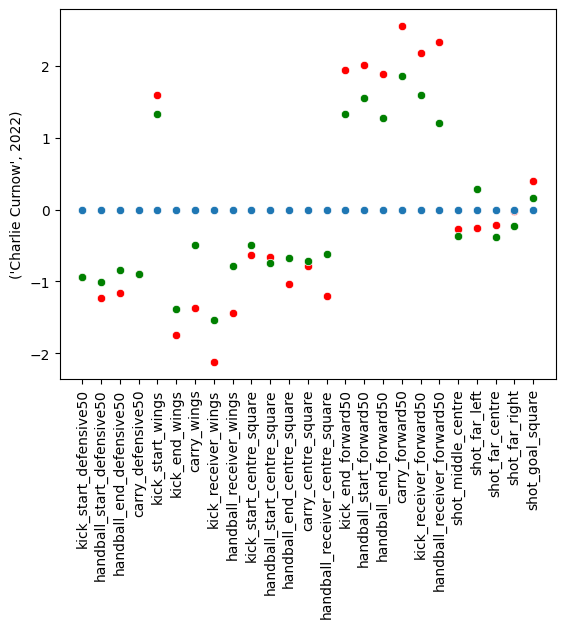

In [80]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Charlie Curnow", 2022)], color="red")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Charlie Curnow", 2023)], color="green")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.mean())
plt.xticks(rotation=90);


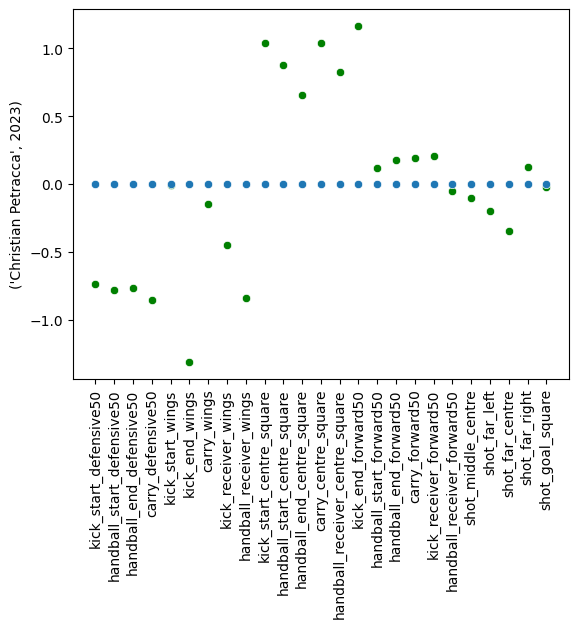

In [81]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Christian Petracca", 2023)], color="green")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.mean())
plt.xticks(rotation=90);

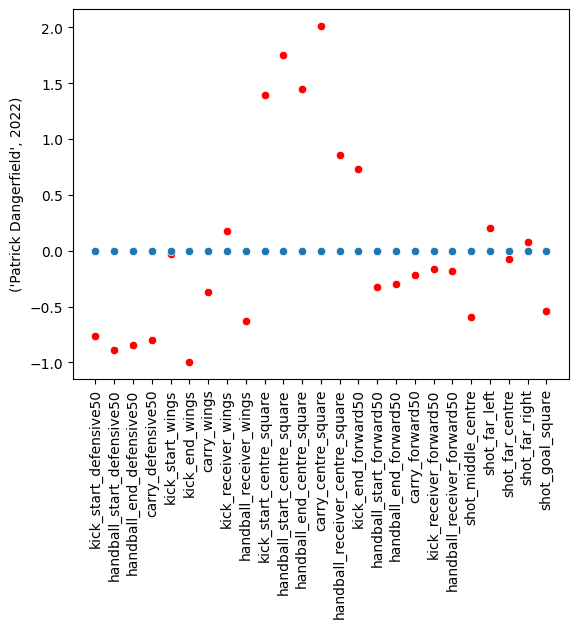

In [82]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Patrick Dangerfield", 2022)], color="red")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.mean())
plt.xticks(rotation=90);

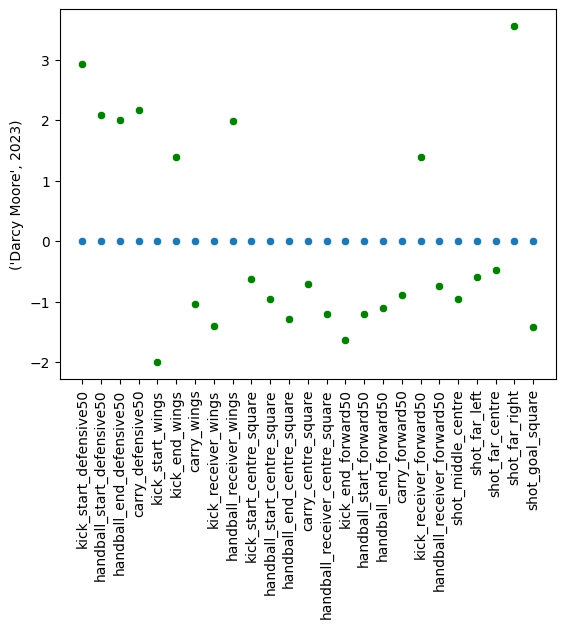

In [83]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Darcy Moore", 2023)], color="green")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.mean())
plt.xticks(rotation=90);

Similar Players

In [84]:
z_player_vectors_df.head()

,,kick_start_defensive50,handball_start_defensive50,handball_end_defensive50,carry_defensive50,kick_start_wings,kick_end_wings,carry_wings,kick_receiver_wings,handball_receiver_wings,kick_start_centre_square,handball_start_centre_square,handball_end_centre_square,carry_centre_square,handball_receiver_centre_square,kick_end_forward50,handball_start_forward50,handball_end_forward50,carry_forward50,kick_receiver_forward50,handball_receiver_forward50,shot_middle_centre,shot_far_left,shot_far_centre,shot_far_right,shot_goal_square
Billy Frampton,2021,0.833279,0.171084,0.381342,0.430529,-0.736534,1.044364,-0.292562,-0.407936,0.094877,-0.480840,-0.696063,-0.512037,-0.784470,-0.899400,-1.130975,0.486949,0.121891,0.351910,0.470605,0.726865,-0.579252,0.012043,0.372915,0.337920,0.081498
Dan Houston,2022,0.909170,0.909992,0.944284,0.541588,-0.687785,1.143083,0.921217,0.524323,0.350726,-0.429748,-0.489385,-0.348628,-0.615599,-0.008652,-1.144650,-0.708875,-0.760604,-0.889683,-0.565073,-0.436015,-0.125256,1.233252,-0.109500,-0.678909,-1.364946
Ben Brown,2021,-0.932517,-1.237278,-0.837248,-0.893117,1.569203,-1.229707,-1.182957,-1.569136,-1.507982,-0.632549,0.206092,-0.297557,-0.589315,-1.202613,0.937942,1.294654,0.784517,2.260437,1.613495,2.792974,-0.072217,-0.460656,-0.476113,0.051458,0.543871
Connor West,2021,-0.578375,-0.712368,-0.665049,-0.837850,0.773479,-0.080744,1.411758,0.831568,-0.628962,-0.535852,0.417045,0.388919,-0.270088,0.275883,-0.031538,0.322981,0.305791,-0.044092,-0.602228,0.268506,0.168243,-0.466539,-0.476113,-0.755565,0.826993
Tarryn Thomas,2021,-0.351717,-0.699430,-0.818905,-0.472377,0.116112,-0.494190,-0.126031,-0.353209,-1.308556,0.374083,1.400645,1.357755,1.047956,2.106446,0.419432,-0.282528,-0.204799,-0.140237,0.375365,-0.463785,-0.309048,-0.088669,0.133027,0.312555,-0.135968


In [85]:
def manhattan_distance(x, y):
    
    return sum(abs(x - y)) 

In [86]:
def calculate_manhattan_similarity(player_vector, player_matrix):
    return player_matrix.apply(lambda row: manhattan_distance(player_vector, row), axis=1)

In [87]:
player, season = "Darcy Moore", 2023
player_vector = z_player_vectors_df.loc[(player, season)]
player_similarity = calculate_manhattan_similarity(player_vector, z_player_vectors_df)
player_similarity.sort_values().head()

Darcy Moore      2023    0.000000
Steven May       2021    4.080559
Griffin Logue    2023    4.892193
Charlie Ballard  2023    5.157338
Alex Keath       2021    6.596672
dtype: float64

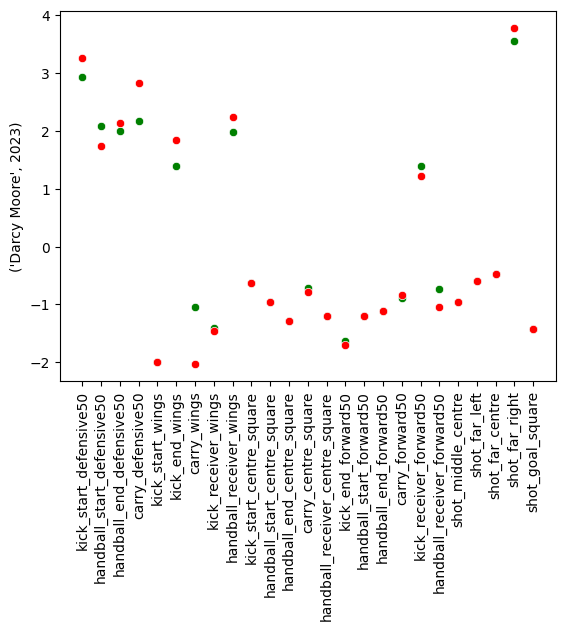

In [89]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Darcy Moore", 2023)], color="green")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Steven May", 2021)], color="red")
plt.xticks(rotation=90);

In [90]:
player, season = "Patrick Dangerfield", 2022
player_vector = z_player_vectors_df.loc[(player, season)]
player_similarity = calculate_manhattan_similarity(player_vector, z_player_vectors_df)
player_similarity.sort_values().head()

Patrick Dangerfield  2022    0.000000
Tom Liberatore       2021    4.584383
Christian Petracca   2021    4.706508
Patrick Cripps       2022    5.345473
Jade Gresham         2022    5.870110
dtype: float64

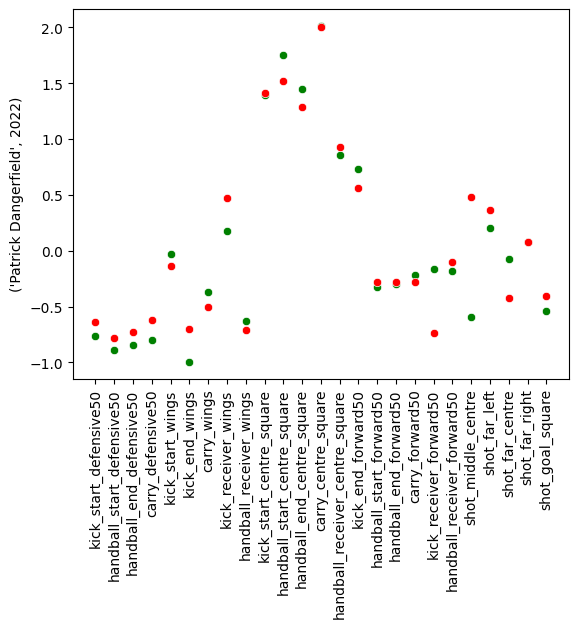

In [91]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Patrick Dangerfield", 2022)], color="green")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Tom Liberatore", 2021)], color="red")
plt.xticks(rotation=90);

In [92]:
player, season = "Christian Petracca", 2022
player_vector = z_player_vectors_df.loc[(player, season)]
player_similarity = calculate_manhattan_similarity(player_vector, z_player_vectors_df)
player_similarity.sort_values().head()

Christian Petracca   2022    0.000000
                     2021    3.479615
Marcus Bontempelli   2022    4.798012
Patrick Dangerfield  2023    5.016571
Jade Gresham         2022    5.395961
dtype: float64

In [93]:
player, season = "Christian Petracca", 2023
player_vector = z_player_vectors_df.loc[(player, season)]
player_similarity = calculate_manhattan_similarity(player_vector, z_player_vectors_df)
player_similarity.sort_values().head()

Christian Petracca  2023    0.000000
Chad Wingard        2021    4.352913
Shai Bolton         2023    5.296181
Brandan Parfitt     2022    5.384641
Marcus Bontempelli  2022    5.438539
dtype: float64

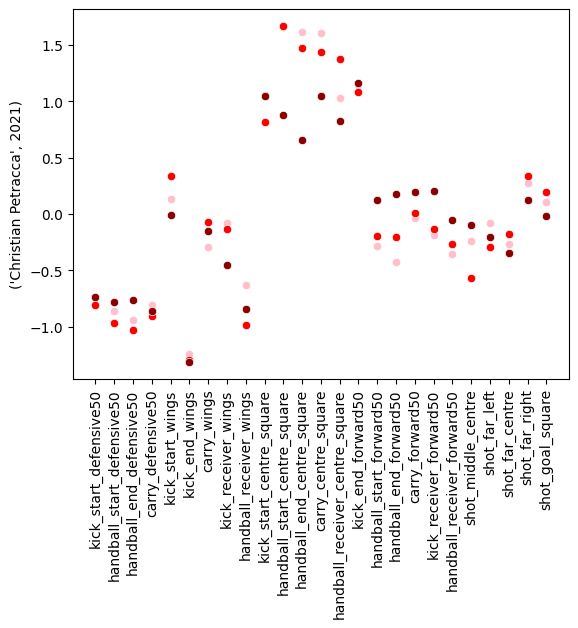

In [94]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Christian Petracca", 2021)], color="pink")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Christian Petracca", 2022)], color="red")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Christian Petracca", 2023)], color="darkred")
plt.xticks(rotation=90);

In [95]:
player, season = "Nick Daicos", 2023
player_vector = z_player_vectors_df.loc[(player, season)]
player_similarity = calculate_manhattan_similarity(player_vector, z_player_vectors_df)
player_similarity.sort_values().head()

Nick Daicos    2023    0.000000
Mark O'Connor  2021    7.351607
Mitch Duncan   2023    7.619328
Sam Walsh      2022    7.698426
Callum Mills   2021    7.814759
dtype: float64

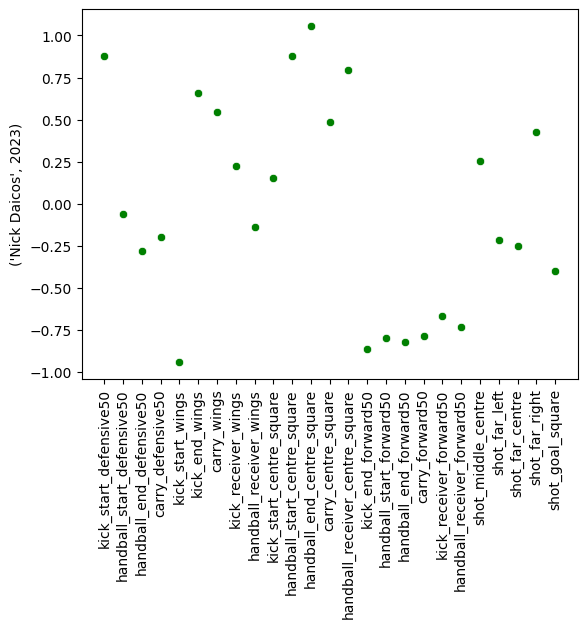

In [100]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Nick Daicos", 2023)], color="green")
plt.xticks(rotation=90);

In [101]:
player, season = "Charlie Curnow", 2023
player_vector = z_player_vectors_df.loc[(player, season)]
player_similarity = calculate_manhattan_similarity(player_vector, z_player_vectors_df)
player_similarity.sort_values().head()

Charlie Curnow    2023    0.000000
Jeremy Cameron    2023    3.807566
Cameron Zurhaar   2022    3.871225
Alec Waterman     2021    4.176540
Jacob van Rooyen  2023    4.210281
dtype: float64

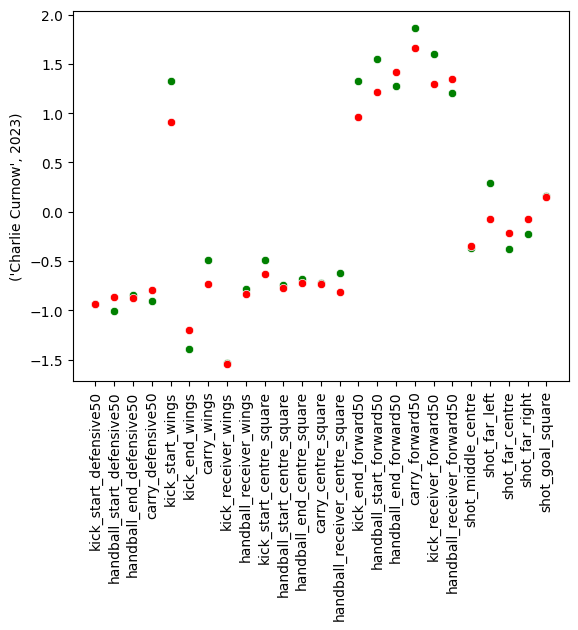

In [103]:
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Charlie Curnow", 2023)], color="green")
sns.scatterplot(x=z_player_vectors_df.columns, y=z_player_vectors_df.loc[("Jeremy Cameron", 2023)], color="red")

plt.xticks(rotation=90);